In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from pyshred import DataManager, SHRED, SHREDEngine, MLP, PI_SHRED, LSTM, LSTM_PI, PI_SHRED_V2, MLP_TRUNK
from matplotlib.tri import Triangulation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, random_split
import Master_utilz as utilz

## Setting the CUDA stuff

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
folder_path = "playground/"
# folder_path = "planewave_with_frequency/"
counter = 0
data_loaded = []
skips = 11

print("Loading training data...")

for file in os.listdir(folder_path):
    if file.endswith(".csv") and file.startswith("train"):
        if counter == 0: 
            path = os.path.join(folder_path, file)
            data_temp, tri = utilz.load_square_comsol_data(path, verbose=True)
            data_temp = data_temp[0::skips,:]
            data_loaded.append(data_temp)
            counter += 1
            
        else:
            path = os.path.join(folder_path, file)
            data_temp, _ = utilz.load_square_comsol_data(path, verbose=True)
            data_temp = data_temp[0::skips,:]
            data_loaded.append(data_temp)
            # counter += len(data_temp)
            # print(counter)
            # if counter >= 5:
                # break
test_data = []
print("Loading test data...")
for file in os.listdir(folder_path):
    if file.endswith(".csv") and file.startswith("test"):
        path = os.path.join(folder_path, file)
        test_data_temp, _ = utilz.load_square_comsol_data(path, verbose=True)
        test_data_temp = test_data_temp[0::skips,:]
        test_data.append(test_data_temp)

Loading training data...
Data loaded from playground/train_square_3circles_A1000_F1000.csv
Number of spatial points inside the circle: 3312
Number of time steps: 9301
Loading test data...
Data loaded from playground/test_square_3circles_A1000_F1000.csv
Number of spatial points inside the circle: 3312
Number of time steps: 501


In [4]:
N = len(data_loaded[0])
interval_start = 0.007
interval_end = 0.1
interval_length = interval_end-interval_start
delta_t = interval_length/N

c = 342.204
rho = 0.0034112
print(delta_t**2)

1.2084402193048639e-08


## Prepare data

In [8]:
print("Data shape:", data_loaded[0].shape)

Data shape: (846, 3312)


shape of X torch.Size([3, 30, 320])
shape of coords torch.Size([3, 3312, 2])
shape of y torch.Size([3, 3312])


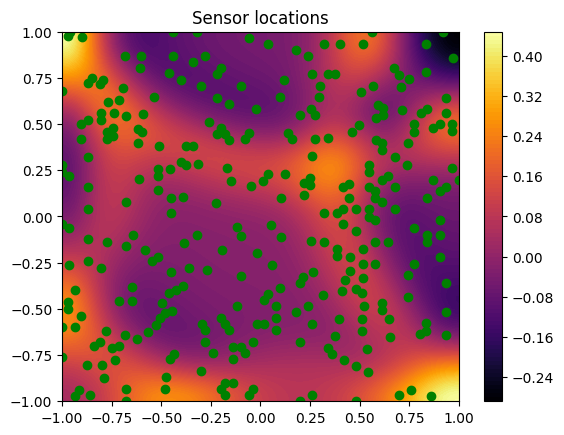

In [5]:
nr_sensors = 320
# sensors = utilz.generate_circle_sensors_from_tri(nr_sensors, tri,circle_fraction=[np.pi,3/2*np.pi/-0.3],scale= 0.75)
# _, U_r = utilz.qr_place(data_loaded[0].T,nr_sensors)
sensors = np.random.choice(np.arange(0,data_temp.shape[1]),nr_sensors,replace = False)
# sensors_2 = generate_circle_sensors_from_tri(nr_sensors, tri,scale = 0.3)
# sensors_3 = generate_circle_sensors_from_tri(nr_sensors, tri,scale = 0.5,circle_fraction = [0, 2*np.pi])
# for i in sensors_2:
#     sensors.append(i)

# for i in sensors_3:
#     sensors.append(i)

fig,ax = plt.subplots()
plt.title("Sensor locations")
cfg1 = ax.tricontourf(tri, data_loaded[0][0,:], levels=100,cmap = "inferno")
for i in sensors:
    ax.plot(tri.x[i],tri.y[i],color = "green", marker = "o")
fig.colorbar(cfg1, ax=ax)

lags = 30

X_train, y_train, scaler = utilz.data_prepare(data_loaded, lags, sensors)

# # X_test, y_test = utilz.data_prepare(test_data, lags, [s[0] for s in sensors], scaler=scaler)
# X_test, y_test = utilz.data_prepare(test_data, lags, sensors=sensors, scaler=scaler)
# test_data_dict = {
#     'X':X_test,
#     'y':y_test,
#     'scaler':scaler
# }

nr_frames = 4
X_all = X_train[:nr_frames,:,:]
y_all = y_train[:nr_frames,:]
coords_all = np.array([tri.x, tri.y]).T

train_data_dict_points = {
    'X':X_all,
    "coords" : coords_all,
    'y':y_all,
}
model_dtype = torch.float32
dataset = utilz.SHREDdata_PI(train_data_dict_points)
train_dataset, val_dataset, _ = dataset.split_data(train_ratio = 0.8,val_ratio=0.2, test_ratio=0.0, sequential_split=True)
train_dataset = train_dataset.move_to_device(device, model_dtype = model_dtype)
val_dataset = val_dataset.move_to_device(device, model_dtype = model_dtype)

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=100)
val_loader = DataLoader(val_dataset,shuffle = False, batch_size=  1)

for X, coords, y in train_loader:
    print("shape of X", X.shape)
    print("shape of coords",coords.squeeze(0).shape)
    print("shape of y", y.shape)
    break

# Make points wise data

## Training the model

In [359]:
from torch.autograd import grad

# model_dtype = torch.float32
torch.set_default_dtype(model_dtype)
seqence_model = LSTM_PI(hidden_size=128, num_layers=3)
trunk_model = MLP_TRUNK(hidden_sizes=[28,128,250], dropout=0.0)
shred = PI_SHRED_V2(sequence_model=seqence_model,
    decoder_model=trunk_model)

shred.sequence.initialize(input_size=X_train.shape[2], lags=lags, decoder_type="MLP_PI",dtype = model_dtype)
shred.trunk_model.initialize(input_size=2, output_size=shred.sequence.hidden_size)

shred.to(device, dtype=model_dtype)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(shred.parameters(), lr=0.001)
# Z =0

lambda_PDE = 0.0
shred.train()
for epoch in range(60000):
    # print(f"Epoch {epoch}")
    epoch_loss = 0.0
    for X,coords, y in train_loader:
        coords = coords[0]
        coords.requires_grad_()

        optimizer.zero_grad()
        output_t, output_tm1,output_tm2 = shred.forward(X, coords)
        LSTM_diff = output_t - output_tm1
        # print("lstm diff shape:", LSTM_diff.shape)
        y_true_diff = y[1:,:] - y[:-1,:]
        # y_true_diff = y[1:,:] - y
        # print("y true diff shape:", y_true_diff.shape)
        LSTM_loss = criterion(LSTM_diff[1:], y_true_diff)
        # print("LSTM loss:", LSTM_loss.item())
        # print(coords[:,0])
        ddt = (output_t-2*output_tm1+output_tm2)/(delta_t**2)
        ddt = ddt.squeeze(0)
        # print("dtt shape", ddt.shape)
        # print("dxx shape", dxx_fd.shape)
        # print("dyy shape", dyy_fd.shape)
        # ddt = torch.sum(ddt,dim =0)

        grads = grad(output_t[0], coords, torch.ones_like(output_t[0]),retain_graph = True, create_graph=True)[0]
        gradsgrads = grad(grads, coords, torch.ones_like(grads),retain_graph = True, create_graph=True)[0]
        dxx = gradsgrads[:,0]
        dyy = gradsgrads[:,1]

        # print("dxx",dxx.shape)
        # print("dyy",dyy.shape)
        # print("ddt",ddt.shape)
        c = 342.204
        rho = 0.0034112
        PDE_term = 1/(c**2) * ddt[0] - (dxx + dyy)
        # print("PDE term shape:", PDE_term.shape)
        PDE_loss = criterion(torch.zeros_like(PDE_term),PDE_term)
        # break


        lambda_PDE = torch.sigmoid((torch.tensor(epoch)-20000)/1000)*0.01
        loss = criterion(output_t, y)#+PDE_loss*lambda_PDE
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        # break
    if (epoch % 100) == 0:
        print(f"at epoch {epoch} the data loss is {epoch_loss} and the PDE loss sum is {torch.sum(PDE_loss).item()} and LSTM loss is {LSTM_loss.item()} ")
        print("lambda PDE:", lambda_PDE.item())
        # print("PDE term:", 1/(c**2) * ddt - (dxx + dyy))
    # break
# print(coords.shape)
fig,ax = plt.subplots(3,2, figsize=(18,10))
cfg1 = ax[0,0].tricontourf(tri, LSTM_diff[0].detach().cpu().numpy(), levels=100,cmap = "inferno")
fig.colorbar(cfg1, ax=ax[0,0])
ax[0,0].set_title("Model LSTM difference")
# cfg2 = ax[0,1].tricontourf(tri, y_true_diff[0].detach().cpu().numpy(), levels=100,cmap = "inferno")
# fig.colorbar(cfg2, ax=ax[0,1])


Yay LSTM_PI has been initialized
Yay LSTM_PI has been initialized
yaaay we are initializing MLP_PI
at epoch 0 the data loss is 0.20748485624790192 and the PDE loss sum is 21.82635498046875 and LSTM loss is 0.0008422529208473861 
lambda PDE: 2.061153678289962e-11
at epoch 100 the data loss is 0.006188361905515194 and the PDE loss sum is 2.0438344478607178 and LSTM loss is 0.0005941918352618814 
lambda PDE: 2.2779278463502806e-11
at epoch 200 the data loss is 0.004441633354872465 and the PDE loss sum is 1.925668478012085 and LSTM loss is 0.000570789270568639 
lambda PDE: 2.5175006176936243e-11
at epoch 300 the data loss is 0.003597378497943282 and the PDE loss sum is 1.9643690586090088 and LSTM loss is 0.0005588768399320543 
lambda PDE: 2.7822641759933653e-11
at epoch 400 the data loss is 0.003054190892726183 and the PDE loss sum is 1.9347608089447021 and LSTM loss is 0.0005475705256685615 
lambda PDE: 3.074878546227566e-11
at epoch 500 the data loss is 0.0027797569055110216 and the PDE 

KeyboardInterrupt: 

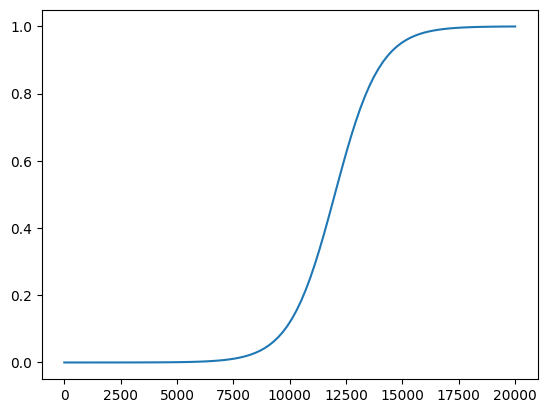

In [56]:
fig,ax = plt.subplots()
ax.plot(torch.tensor(np.linspace(0,20000,100)),torch.sigmoid(torch.tensor(np.linspace(0,20000,100)-12000)/1000))

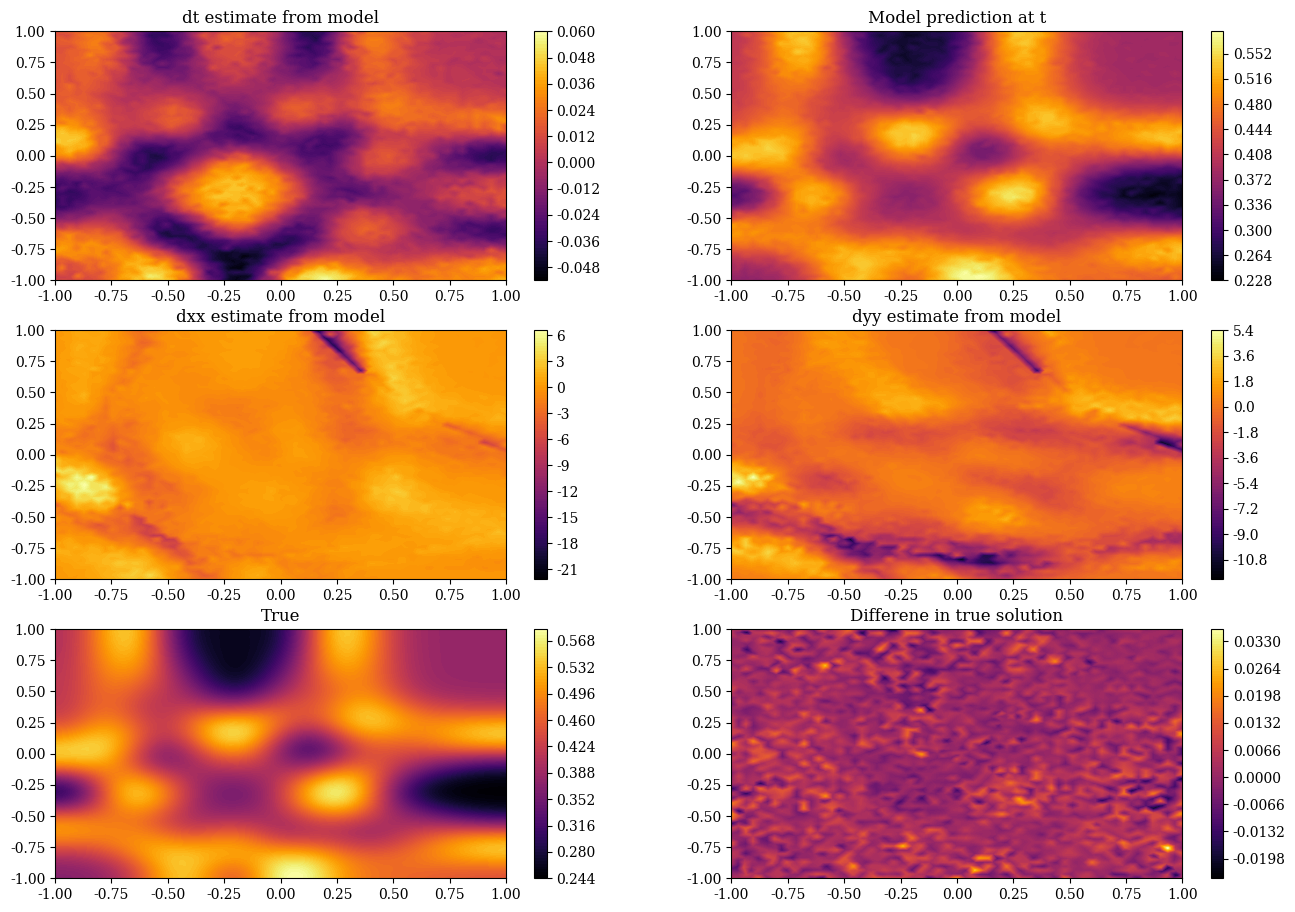

In [365]:
#Setting the font of the plots to match that of latex
plt.rcParams.update({
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",       # Computer Modern for math
    "axes.unicode_minus": False,    # So minus sign appears correctly
})


fig,ax = plt.subplots(3,2, figsize=(16,11))
cfg1 = ax[0,0].tricontourf(tri, LSTM_diff[0].detach().cpu().numpy(), levels=100,cmap = "inferno")
fig.colorbar(cfg1, ax=ax[0,0])
ax[0,0].set_title("dt estimate from model")
cfg2 = ax[0,1].tricontourf(tri, output_t[0].detach().cpu().numpy(), levels=100,cmap = "inferno")
fig.colorbar(cfg2, ax=ax[0,1])
ax[0,1].set_title("Model prediction at t")
cfg3 = ax[1,0].tricontourf(tri, dxx.detach().cpu().numpy(), levels=100,cmap = "inferno")
fig.colorbar(cfg3, ax=ax[1,0])
ax[1,0].set_title("dxx estimate from model")
cfg4 = ax[1,1].tricontourf(tri, dyy.detach().cpu(), levels=100,cmap = "inferno")
ax[1,1].set_title("dyy estimate from model")
fig.colorbar(cfg4, ax=ax[1,1])
cfg4 = ax[2,0].tricontourf(tri, y[0].detach().cpu(), levels=100,cmap = "inferno")
ax[2,0].set_title("True")
fig.colorbar(cfg4, ax=ax[2,0])
cfg4 = ax[2,1].tricontourf(tri, y[0].detach().cpu() - output_t[0].detach().cpu().numpy(), levels=100,cmap = "inferno")
ax[2,1].set_title("Differene in true solution")
fig.colorbar(cfg4, ax=ax[2,1])

# Visualize the SHRED predictions

In [328]:
visualize_loader = DataLoader(train_dataset, shuffle=False, batch_size=3)
test_index = 1
shred.eval()
for index ,data in enumerate(visualize_loader): 
    # optimizer.zero_grad()
    if index == test_index-1:
        X, coords, y = data
        print("yay")
        y_true_tm1 = y.detach().cpu().numpy()[0]
    
    if index == test_index:
        X, coords, y = data.copy()
        print("X shape", X.shape)
        print("coords shape for visualization:", coords.shape)
        coords = coords[0]
        coords.requires_grad_()
        output_t, output_tm1,output_tm2 = shred.forward(X, coords) # output_t shape (Nt (3), Nxy)
        print("output_t shape", output_t.shape)
        ddt = 1/c**2*(output_t-2*output_tm1+output_tm2)/(delta_t**2)

        print("dtt shape", ddt.shape)
        grads = grad(output_t, coords, torch.ones_like(output_t), create_graph=True)[0]#Wee huu here grads are computed as sum over the time domain not good! FIX this # grads shape (Nxy (3312), input_dim of coords (2))
        print("grads shape", grads.shape)
        gradsgrads = grad(grads, coords, torch.ones_like(grads), create_graph=True)[0] # gradsgrads shape (Nxy (3312), input_dim of coords (2))
        print("gradsgrads shape", gradsgrads.shape)
        dxx = gradsgrads[:,0]
        print("dxx shape", dxx.shape)
        dyy = gradsgrads[:,1]

        PDE_term = 1/(c**2) * ddt - (dxx + dyy)
        print("PDE term fd shape", PDE_term.shape)
        loss = criterion(torch.zeros_like(PDE_term),PDE_term)
        print("PDE loss fd:", loss.item())

        output_t = output_t.detach().cpu().numpy()[0]
        output_tm1 = output_tm1.detach().cpu().numpy()[0]
        output_tm2 = output_tm2.detach().cpu().numpy()[0]
        break
print(dxx.shape)



yay
torch.Size([3312])


ValueError: z array must have same length as triangulation x and y arrays

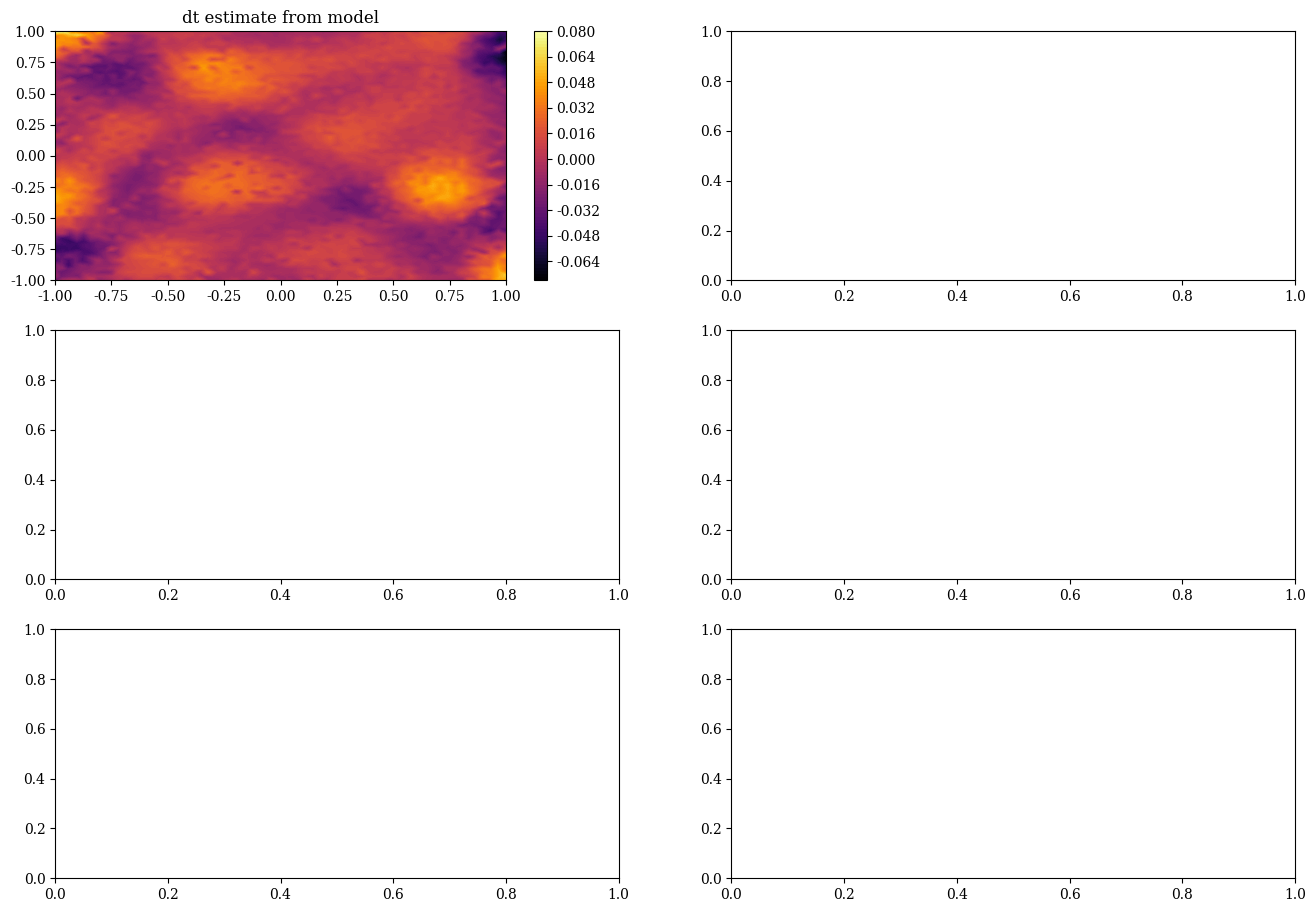

In [329]:
fig,ax = plt.subplots(3,2, figsize=(16,11))
cfg1 = ax[0,0].tricontourf(tri, LSTM_diff[0].detach().cpu().numpy(), levels=100,cmap = "inferno")
fig.colorbar(cfg1, ax=ax[0,0])
ax[0,0].set_title("dt estimate from model")
cfg2 = ax[0,1].tricontourf(tri, ddt.detach().cpu()[0], levels=100,cmap = "inferno")
fig.colorbar(cfg2, ax=ax[0,1])
ax[0,1].set_title("dtt estimate from model")
cfg3 = ax[1,0].tricontourf(tri, dxx.detach().cpu().numpy(), levels=100,cmap = "inferno")
fig.colorbar(cfg3, ax=ax[1,0])
ax[1,0].set_title("dxx estimate from model")
# cfg4 = ax[1,1].tricontourf(tri, y_true_diff[0].detach().cpu().numpy(), levels=100,cmap = "inferno")
# ax[1,1].set_title("True dt")
# fig.colorbar(cfg4, ax=ax[1,1])
cfg4 = ax[2,0].tricontourf(tri,dyy.detach().cpu() , levels=100,cmap = "inferno")
ax[2,0].set_title("dyy estimate from model")
fig.colorbar(cfg4, ax=ax[2,0])
cfg4 = ax[2,1].tricontourf(tri,y[-1].detach().cpu() , levels=100,cmap = "inferno")
ax[2,1].set_title("True solution ")
fig.colorbar(cfg4, ax=ax[2,1])

In [167]:
len(grads_temp)

1

ValueError: z array must have same length as triangulation x and y arrays

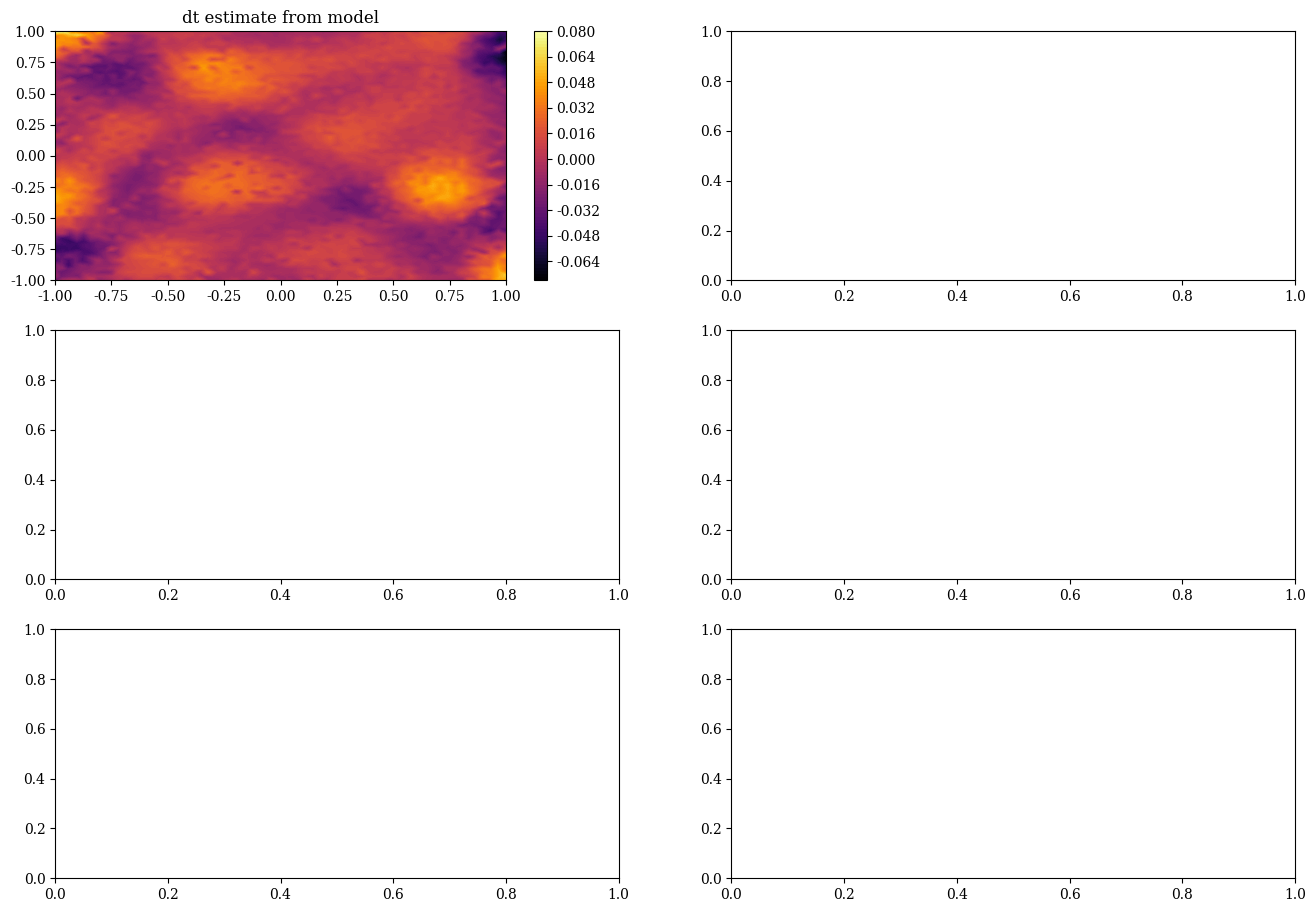

In [330]:
#Setting the font of the plots to match that of latex
plt.rcParams.update({
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",       # Computer Modern for math
    "axes.unicode_minus": False,    # So minus sign appears correctly
})


fig,ax = plt.subplots(3,2, figsize=(16,11))
cfg1 = ax[0,0].tricontourf(tri, LSTM_diff[0].detach().cpu().numpy(), levels=100,cmap = "inferno")
fig.colorbar(cfg1, ax=ax[0,0])
ax[0,0].set_title("dt estimate from model")
cfg2 = ax[0,1].tricontourf(tri, ddt.detach().cpu()[0], levels=100,cmap = "inferno")
fig.colorbar(cfg2, ax=ax[0,1])
ax[0,1].set_title("dtt estimate from model")
cfg3 = ax[1,0].tricontourf(tri, dxx.detach().cpu().numpy(), levels=100,cmap = "inferno")
fig.colorbar(cfg3, ax=ax[1,0])
ax[1,0].set_title("dxx estimate from model")
cfg4 = ax[1,1].tricontourf(tri, y_true_diff[0].detach().cpu().numpy(), levels=100,cmap = "inferno")
ax[1,1].set_title("True dt")
fig.colorbar(cfg4, ax=ax[1,1])
cfg4 = ax[2,0].tricontourf(tri,dyy.detach().cpu() , levels=100,cmap = "inferno")
ax[2,0].set_title("dyy estimate from model")
fig.colorbar(cfg4, ax=ax[2,0])
cfg4 = ax[2,1].tricontourf(tri,y[-1].detach().cpu() , levels=100,cmap = "inferno")
ax[2,1].set_title("True solution ")
fig.colorbar(cfg4, ax=ax[2,1])

In [88]:
print(ddt.shape)

torch.Size([1, 3312])


# Create the data for the GIF

In [8]:
visualize_loader = DataLoader(train_dataset, shuffle=False, batch_size=1)
# y_all = val_dataset.Y.cpu().numpy()
#plot with sensors locations
# _, U_r = utilz.qr_place(data_loaded[0].T,nr_sensors)
test_index = 0
svd_pred_list = []
shred_pred_list = []
true_sol_list = []
error_svd_list = []
error_shred_list = []

for i, (data) in enumerate(visualize_loader):
    X, coords, y = data
    shred_pred = shred.forward(X,coords[0])[0].detach().cpu().numpy()[0]
    # SVD_pred = utilz.SVD_pod_reconstruction(U_r, y_test[0,:], sensors, r=r)
    y_true = y.detach().cpu().numpy()[0]
    true_sol_list.append(y_true)

    # svd_pred_list.append(SVD_pred)
    shred_pred_list.append(shred_pred)

    # abs_error_svd = y_test[0,:] - SVD_pred
    abs_error_shred = y_true - shred_pred
    
    # error_svd_list.append(abs_error_svd)
    error_shred_list.append(abs_error_shred)


# Collecting all images for the GIF

In [9]:
from io import BytesIO
from PIL import Image
nr_images = len(shred_pred_list)

true_max = np.max(true_sol_list)
true_min = np.min(true_sol_list)
pred_levels = np.linspace(true_min, true_max,100)

# error_svd_hist = np.zeros(len(error_svd_list))
error_shred_hist = np.zeros(len(shred_pred_list))
for i in range(len(error_shred_hist)):
    # error_svd_hist[i] = np.max(error_svd_list[i])
    error_shred_hist[i] = np.max(error_shred_list[i])

# svd_error_max = np.max(error_svd_list)
# svd_error_min = np.min(error_svd_list)
# svd_error_levels = np.linspace(svd_error_min,svd_error_max, 100)

shred_error_max = np.max(error_shred_list)
shred_error_min = np.min(error_shred_list)
shred_error_levels = np.linspace(shred_error_min, shred_error_max,100)

images = []
for i in range(nr_images):
    print(f"starting loop {i}")
    if i == 10:
        break
    i = i*10

    fig,ax = plt.subplots(2,2,figsize=(16,8))
    plt.suptitle(f"Reconstructions using {nr_sensors} sensors with a time history of {lags} steps", fontsize=16)
    cb_true = ax[0,0].tricontourf(tri, true_sol_list[i], levels=pred_levels,cmap = "inferno")
    fig.colorbar(cb_true, ax=ax[0,0])
    ax[0,0].set_title("True solution")
    cb_shred = ax[0,1].tricontourf(tri, shred_pred_list[i], levels=pred_levels,cmap = "inferno")
    fig.colorbar(cb_shred, ax=ax[0,1])
    ax[0,1].set_title("Reconstruction with SHRED")
    # cb_svd = ax[0,2].tricontourf(tri, svd_pred_list[i], levels=pred_levels,cmap = "inferno")
    # fig.colorbar(cb_svd, ax=ax[0,2])
    # ax[0,2].set_title("Reconstruction with SVD PODs")
    # error_svd = ax[1,2].tricontourf(tri, error_svd_list[i], levels=svd_error_levels,cmap = "inferno")
    # ax[1,2].set_title(r"error: $u_{true}-u_{SVD}$")
    error_shred = ax[1,1].tricontourf(tri, error_shred_list[i], levels=shred_error_levels,cmap = "inferno")
    ax[1,1].set_title(r"error: $u_{true}-u_{SHRED}$")
    # fig.colorbar(error_svd, ax=ax[1,2])
    fig.colorbar(error_shred, ax=ax[1,1])
    for i in sensors:
        if i == sensors[0]:
            ax[0,0].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
            ax[0,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
            # ax[0,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
            ax[1,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
            # ax[1,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
        else:
            ax[0,0].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
            ax[0,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
            # ax[0,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
            ax[1,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
            # ax[1,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
    ax[0,0].legend(loc = "upper left")

    # max_error = np.amax([error_svd_hist,error_shred_hist])
    max_error = np.amax(error_shred_hist)
    N_bins = 20
    bin_w = max_error / N_bins
    bin_edges = np.arange(0,N_bins) * bin_w
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # error_svd_hist_counts, _ = np.histogram(error_svd_hist, bins=bin_edges)
    error_shred_hist_counts, _ = np.histogram(error_shred_hist, bins=bin_edges)
    ax[1,0].set_title("max abs-error distribution over all predictions")
    # ax[1,0].bar(bin_centers, error_svd_hist_counts, width=bin_w,alpha = 0.7, edgecolor="k",label = "svd-errors")
    ax[1,0].bar(bin_centers, error_shred_hist_counts, width=bin_w, alpha=0.7, edgecolor="k",label = "shred-errors")
    ax[1,0].legend()
    ax[1,0].set_ylabel("count")
    ax[1,0].set_xlabel("max abs error")

    buf = BytesIO()
    plt.savefig(buf, format = 'png')
    buf.seek(0)
    images.append(Image.open(buf))
    plt.close(fig)
    plt.show()

starting loop 0
starting loop 1
starting loop 2
starting loop 3
starting loop 4
starting loop 5
starting loop 6
starting loop 7
starting loop 8
starting loop 9
starting loop 10


# Saving the GIF

In [10]:
images[0].save("playground/PI_test_2.gif", save_all = True, append_images = images[1:],duration = 500, loop= 0)

# LSTM tests


In [ ]:
import torch.nn as nn
input_size = 5
hidden_size = 10
num_layers = 2
rnn = nn.LSTM(input_size, hidden_size, num_layers)
L = 5
N = 3
Hin = 5
input = torch.randn(L, N, Hin)

Hout=10
h0 = torch.randn(num_layers, N, Hout)
Hcell = 10
c0 = torch.randn(num_layers, N, Hcell)
output, (hn, cn) = rnn(input, (h0, c0))
print("output", output.shape)
print("hn",hn.shape)
print("cn",cn.shape)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from random import uniform

class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f):
        # x & t from boundary conditions:
        self.x_u = torch.tensor(X_u[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_u = torch.tensor(X_u[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)

        # x & t from collocation points:
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)

        # boundary solution:
        self.u = torch.tensor(u, dtype=torch.float32)

        # null vector to test against f:
        self.null =  torch.zeros((self.x_f.shape[0], 1))

        # initialize net:
        self.create_net()
        #self.net.apply(self.init_weights)

        # this optimizer updates the weights and biases of the net:
        self.optimizer = torch.optim.LBFGS(self.net.parameters(),
                                    lr=1,
                                    max_iter=50000,
                                    max_eval=50000,
                                    history_size=50,
                                    tolerance_grad=1e-05,
                                    tolerance_change=0.5 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")

        # typical MSE loss (this is a function):
        self.loss = nn.MSELoss()

        # loss :
        self.ls = 0

        # iteration number:
        self.iter = 0

    def create_net(self):
        """ net takes a batch of two inputs: (n, 2) --> (n, 1) """
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1))

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight, 0.1)
            m.bias.data.fill_(0.001)
        
    def net_u(self, x, t):
        u = self.net( torch.hstack((x, t)) )
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

        f = u_t + (u * u_x) - (nu * u_xx)

        return f

    def closure(self):
        # reset gradients to zero:
        self.optimizer.zero_grad()
        
        # u & f predictions:
        u_prediction = self.net_u(self.x_u, self.t_u)
        f_prediction = self.net_f(self.x_f, self.t_f)

        # losses:
        u_loss = self.loss(u_prediction, self.u)
        f_loss = self.loss(f_prediction, self.null)
        self.ls = u_loss + f_loss

        # derivative with respect to net's weights:
        self.ls.backward()

        # increase iteration count:
        self.iter += 1

        # print report:
        if not self.iter % 100:
            print('Epoch: {0:}, Loss: {1:6.3f}'.format(self.iter, self.ls))

        return self.ls
        
    def train(self):
        """ training loop """
        self.net.train()
        self.optimizer.step(self.closure)

if __name__ == '__main__' :

    nu = 0.01 / np.pi         # constant in the diff. equation
    N_u = 100                 # number of data points in the boundaries
    N_f = 10000               # number of collocation points

    # X_u_train: a set of pairs (x, t) located at:
        # x =  1, t = [0,  1]
        # x = -1, t = [0,  1]
        # t =  0, x = [-1, 1]
    x_upper = np.ones((N_u//4, 1), dtype=float)
    x_lower = np.ones((N_u//4, 1), dtype=float) * (-1)
    t_zero = np.zeros((N_u//2, 1), dtype=float)

    t_upper = np.random.rand(N_u//4, 1)
    t_lower = np.random.rand(N_u//4, 1)
    x_zero = (-1) + np.random.rand(N_u//2, 1) * (1 - (-1))

    # stack uppers, lowers and zeros:
    X_upper = np.hstack( (x_upper, t_upper) )
    X_lower = np.hstack( (x_lower, t_lower) )
    X_zero = np.hstack( (x_zero, t_zero) )

    # each one of these three arrays haS 2 columns, 
    # now we stack them vertically, the resulting array will also have 2 
    # columns and 100 rows:
    X_u_train = np.vstack( (X_upper, X_lower, X_zero) )

    # shuffle X_u_train:
    index = np.arange(0, N_u)
    np.random.shuffle(index)
    X_u_train = X_u_train[index, :]
    
    # make X_f_train:
    X_f_train = np.zeros((N_f, 2), dtype=float)
    for row in range(N_f):
        x = uniform(-1, 1)  # x range
        t = uniform( 0, 1)  # t range

        X_f_train[row, 0] = x 
        X_f_train[row, 1] = t

    # add the boundary points to the collocation points:
    X_f_train = np.vstack( (X_f_train, X_u_train) )

    # make u_train
    u_upper =  np.zeros((N_u//4, 1), dtype=float)
    u_lower =  np.zeros((N_u//4, 1), dtype=float) 
    u_zero = -np.sin(np.pi * x_zero)  

    # stack them in the same order as X_u_train was stacked:
    u_train = np.vstack( (u_upper, u_lower, u_zero) )

    # match indices with X_u_train
    u_train = u_train[index, :]

    # pass data sets to the PINN:
    pinn = PhysicsInformedNN(X_u_train, u_train, X_f_train)

    pinn.train()